## ESCUELA POLITECNICA NACIONAL

---

Nombre: Anthony Reinoso

## Ejercicio 4: Modelo Probabilístico
###Objetivo de la práctica
* Comprender los componentes del modelo vectorial mediante cálculos manuales y observación directa.
* Aplicar el modelo de espacio vectorial con TF-IDF para recuperar documentos relevantes.
* Comparar la recuperación con BM25 frente a TF-IDF.
* Analizar visualmente las diferencias entre los modelos.
* Evaluar si los rankings generados son consistentes con lo que considerarías documentos relevantes.

###Parte 0: Carga del Corpus

In [37]:
from sklearn.datasets import fetch_20newsgroups

newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
newsgroupsdocs = newsgroups.data

##Parte 1: Cálculo de TF, DF, IDF y TF-IDF
###Actividad
* Utiliza el corpus cargado.
* Construye la matriz de términos (TF), y calcula la frecuencia de documentos (DF)
* Calcula TF-IDF utilizando sklearn.
* Visualiza los valores en un DataFrame para analizar las diferencias entre los términos.

In [38]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import sys

In [39]:
print(f"Número de documentos: {len(newsgroupsdocs)}")
sys.getsizeof(newsgroupsdocs)
print(f"Tamaño en memoria del corpus: {sys.getsizeof(newsgroupsdocs)} bytes")

Número de documentos: 18846
Tamaño en memoria del corpus: 150824 bytes


In [53]:
print("\n=== Matriz de Términos (TF) ===\n")
count_vectorizer = CountVectorizer(max_features=100)  # Limitamos a 100 términos para visualización práctica
tf_matrix = count_vectorizer.fit_transform(newsgroupsdocs)
terms = count_vectorizer.get_feature_names_out()
# DataFrame
tf_df = pd.DataFrame.sparse.from_spmatrix(tf_matrix, columns=terms)
print("Dimensiones de la matriz TF:", tf_df.shape)
print("\nVisualización parcial de la matriz TF (primeros 5 documentos):")
print(tf_df.iloc[:5, :10].to_string())  # Mostramos solo una porción para visualización

# Calcula Frecuencia de Documentos (DF)
print("\n=== Frecuencia de Documentos (DF) ===\n")
df = (tf_matrix > 0).sum(axis=0)
df_series = pd.Series(np.array(df).flatten(), index=terms, name='DF')

print("20 términos más frecuentes:")
print(df_series.sort_values(ascending=False).head(20).to_string())



=== Matriz de Términos (TF) ===

Dimensiones de la matriz TF: (18846, 100)

Visualización parcial de la matriz TF (primeros 5 documentos):
   about  all  also  am  an  and  any  are  as  at
0      2    0     1   3   1    1    1    3   0   0
1      0    0     0   0   0    0    1    0   0   0
2      2    0     0   0   0    8    0    1   0   0
3      0    0     0   0   2    3    1    1   0   0
4      0    0     0   0   3    0    0    0   1   0

=== Frecuencia de Documentos (DF) ===

20 términos más frecuentes:
the     15749
to      14108
and     12991
of      12809
in      11842
is      11685
it      11029
that    10974
for     10406
have     8722
this     8665
on       8596
you      8447
be       8140
with     8063
not      7664
are      7404
but      7395
if       7383
or       7177


In [54]:
# Calcula TF-IDF con Sklearn
print("\n=== Matriz TF-IDF ===\n")
tfidf_vectorizer = TfidfVectorizer(max_features=100)
tfidf_matrix = tfidf_vectorizer.fit_transform(newsgroupsdocs)# Vectorizador del corpus
tfidf_terms = tfidf_vectorizer.get_feature_names_out()

# DataFrame
tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf_matrix, columns=tfidf_terms)
print("Dimensiones de la matriz TF-IDF:", tfidf_df.shape)
print("\nVisualización parcial de la matriz TF-IDF (primeros 5 documentos):")
print(tfidf_df.iloc[:5, :10].to_string())



=== Matriz TF-IDF ===

Dimensiones de la matriz TF-IDF: (18846, 100)

Visualización parcial de la matriz TF-IDF (primeros 5 documentos):
      about  all      also        am        an       and       any       are        as  at
0  0.183814    0  0.109705  0.359041  0.087364  0.054508  0.094365  0.230526         0   0
1         0    0         0         0         0         0  0.323796         0         0   0
2   0.11795    0         0         0         0  0.279811         0  0.049308         0   0
3         0    0         0         0  0.146782  0.137369  0.079272  0.064552         0   0
4         0    0         0         0  0.237271         0         0         0  0.074508   0


In [55]:
print("\n=== Análisis Comparativo ===")
comparison_terms = ['the', 'god']

# DataFrame comparativo
comparison_data = {
    'Término': comparison_terms,
    'DF': [df_series[term] for term in comparison_terms],
    'IDF': [tfidf_vectorizer.idf_[tfidf_vectorizer.vocabulary_[term]] for term in comparison_terms],
    'TF Promedio': [tf_matrix[:, count_vectorizer.vocabulary_[term]].mean() for term in comparison_terms],
    'TF-IDF Promedio': [tfidf_matrix[:, tfidf_vectorizer.vocabulary_[term]].mean() for term in comparison_terms]
}

comparison_df = pd.DataFrame(comparison_data)
print("\nComparación entre términos seleccionados:")
print(comparison_df.to_string(index=False))


=== Análisis Comparativo ===

Comparación entre términos seleccionados:
Término    DF      IDF  TF Promedio  TF-IDF Promedio
    the 15749 1.179513     9.211079         0.281432
    god   947 3.989755     0.180357         0.012589


## Parte 2: Ranking de documentos usando TF-IDF
###Actividad
1. Dada una consulta, construye el vector de consulta
2. Calcula la similitud coseno entre la consulta y cada documento usando los vectores TF-IDF
3. Genera un ranking de los documentos ordenados por relevancia.
4. Muestra los resultados en una tabla.

In [56]:
# Convierte una consulta en un vector TF-IDF usando el vectorizer existente
def get_query_vector(query, tfidf_vectorizer):

  query_vec = tfidf_vectorizer.transform([query])#  consulta con el vectorizador ya entrenado
  return query_vec


In [57]:
# Calcula similitud coseno y rankear documentos (sin normalización explícita)
def rank_documents(query, tfidf_vectorizer, tfidf_matrix, docs, top_n=10):

    print("\n=== Dimensiones de la matriz TF-IDF ===")
    print("Filas (documentos):", tfidf_matrix.shape[0])
    print("Columnas (términos):", tfidf_matrix.shape[1])

    # Obtener vector de consulta
    query_vec = get_query_vector(query, tfidf_vectorizer)

    # Calcular similitud coseno directamente (sin normalizar la matriz)
    similarities = cosine_similarity(query_vec, tfidf_matrix).flatten()
    distances = 1 - similarities  # Distancia = 1 - similitud

    # Obtener índices ordenados por similitud descendente
    ranked_indices = similarities.argsort()[::-1]

    # Crear DataFrame con resultados
    results = pd.DataFrame({
        'Rank': range(1, top_n + 1),
        'Similitud': similarities[ranked_indices][:top_n],
        'Doc ID': ranked_indices[:top_n],
        'Fragmento': [get_normalized_snippet(docs[i]) for i in ranked_indices[:top_n]]
    })

    return results

In [58]:
print("\n=== Ranking de Documentos usando TF-IDF ===")

sample_queries = [
    "New Jersey"
]

for query in sample_queries:
    print(f"\n{'='*80}")
    print(f"\nConsulta: '{query}'")
    ranked_results = rank_documents(
        query=query,
        tfidf_vectorizer=tfidf_vectorizer,
        tfidf_matrix=tfidf_matrix,
        docs=newsgroupsdocs,
        top_n=50
    )
    print(ranked_results.to_string(index=False))



=== Ranking de Documentos usando TF-IDF ===


Consulta: 'New Jersey'

=== Dimensiones de la matriz TF-IDF ===
Filas (documentos): 18846
Columnas (términos): 100
 Rank  Similitud  Doc ID                                                                                               Fragmento
    1   1.000000   13771                                                           nz new zealand au australia jp japan kr korea
    2   1.000000    2457 final american hockey leagu stand northern divis w l t pt gf ga lyf provid bruin adirondack red wing...
    3   0.940202    2270 porsch turbo trim spoiler graphit black all around excel condit remov factori sunroof leather interi...
    4   0.932143    1371 earli to mid june if they think the public want to see it they will carri it whi not write them and ...
    5   0.905692    4393                                                                                 in glassboro new jersey
    6   0.891176   18013 hi everyon here are some book for sale 

##Parte 3: Ranking con BM25
###Actividad
1. Implementa un sistema de recuperación usando el modelo BM25.
2. Usa la misma consulta del ejercicio anterior.
3. Calcula el score BM25 para cada documento y genera un ranking.
4. Compara manualmente con el ranking de TF-IDF.

In [ ]:
!pip install rank-bm25

In [61]:
from rank_bm25 import BM25Okapi
import pandas as pd

# Tokenizar corpus sin normalización
tokenized_corpus = [doc.split() for doc in newsgroupsdocs]
bm25 = BM25Okapi(tokenized_corpus)

# Ranking con BM25 sin normalización
def rank_bm25(query, corpus, bm25_model, top_n=5):
    tokenized_query = query.split()  # sin normalizar
    scores = bm25_model.get_scores(tokenized_query)

    ranked_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:top_n]

    results = pd.DataFrame({
        'BM25 Score': [scores[i] for i in ranked_indices],
        'Fragmento': [get_normalized_snippet(corpus[i]) for i in ranked_indices],
        'Doc ID': ranked_indices
    })

    return results

# Obtener resultados BM25
bm25_results = rank_bm25(query, newsgroupsdocs, bm25)
print("\nResultados BM25:")
print(bm25_results[['BM25 Score', 'Fragmento']].head().to_string(index=False))

# Comparación con TF-IDF (usando el código anterior)
tfidf_results = rank_documents(query, tfidf_vectorizer, tfidf_matrix, newsgroupsdocs)
print("\nResultados TF-IDF:")
print(tfidf_results[['Rank', 'Similitud', 'Fragmento']].head().to_string(index=False))

# Comparación manual
print("\nComparación:")
print("1. BM25 considera frecuencia de términos y longitud de documento")
print("2. TF-IDF normaliza por frecuencia en documento y corpus")
print("3. BM25 generalmente funciona mejor para consultas cortas")


Resultados BM25:
 BM25 Score                                                                                               Fragmento
  16.516238                                                                                 in glassboro new jersey
  14.884210 doe anyon here know where i can find a modem and comm softwar for an appl iie i would prefer in manh...
  14.825611 help im stuck here at a comput in new jersey and have no access to a radio or tv could someon kindli...
  14.539404 s i have a toyota camri delux for sale k mile power everyth grey year newer than abov for k all high...
  14.268785 everyon read thi if you have alreadi sent your predict pleas correct the patrick divis if you would ...

=== Dimensiones de la matriz TF-IDF ===
Filas (documentos): 18846
Columnas (términos): 100

Resultados TF-IDF:
 Rank  Similitud                                                                                               Fragmento
    1   1.000000                                     

# Parte 4: Comparación visual entre TF-IDF y BM25
##Actividad
1. Utiliza un gráfico de barras para visualizar los scores obtenidos por cada documento según TF-IDF y BM25.
2. Compara los rankings visualmente.
3. Identifica: ¿Qué documentos obtienen scores más altos en un modelo que en otro?
4. Sugiere: ¿A qué se podría deber esta diferencia?

In [ ]:
import matplotlib.pyplot as plt


=== Dimensiones de la matriz TF-IDF ===
Filas (documentos): 18846
Columnas (términos): 100


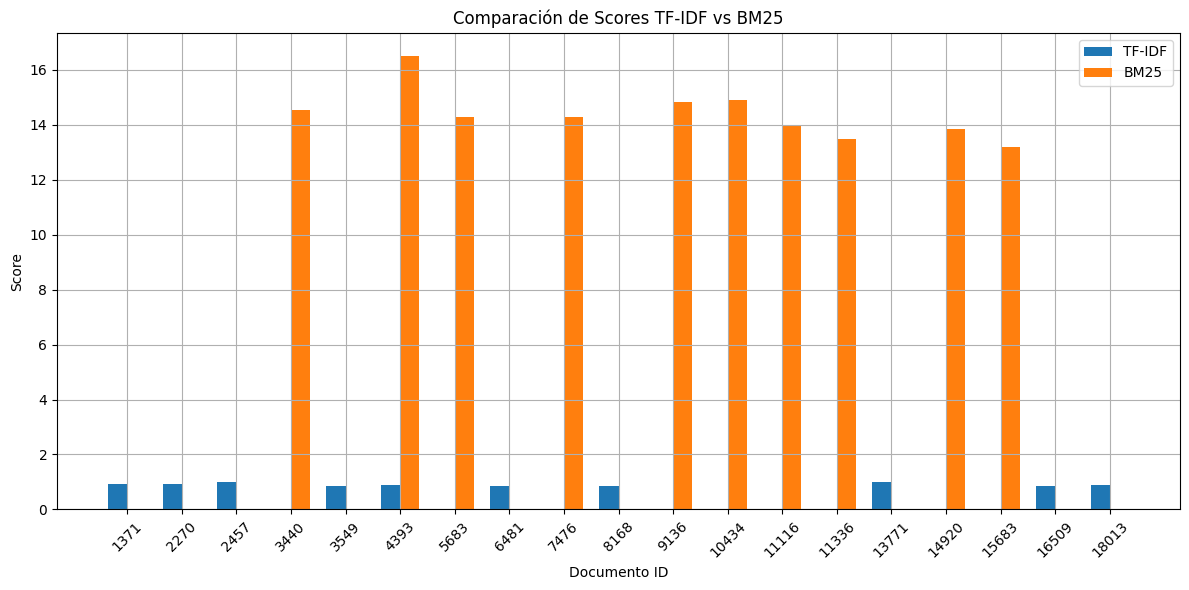

In [63]:
top_n = 10
tfidf_results = rank_documents(query, tfidf_vectorizer, tfidf_matrix, newsgroupsdocs, top_n=top_n)
bm25_results = rank_bm25(query, newsgroupsdocs, bm25, top_n=top_n)

# Unir los resultados por Doc ID
merged = pd.merge(tfidf_results[['Doc ID', 'Similitud']],
                  bm25_results[['Doc ID', 'BM25 Score']],
                  on='Doc ID', how='outer').fillna(0)

# Gráfico de barras
x = merged['Doc ID'].astype(str)
bar_width = 0.35
indices = range(len(x))

plt.figure(figsize=(12, 6))
plt.bar([i - bar_width/2 for i in indices], merged['Similitud'], width=bar_width, label='TF-IDF')
plt.bar([i + bar_width/2 for i in indices], merged['BM25 Score'], width=bar_width, label='BM25')

plt.xticks(indices, x, rotation=45)
plt.xlabel("Documento ID")
plt.ylabel("Score")
plt.title("Comparación de Scores TF-IDF vs BM25")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [64]:
merged['Mayor modelo'] = merged.apply(
    lambda row: 'TF-IDF' if row['Similitud'] > row['BM25 Score'] else 'BM25', axis=1
)
print("\nDocumento con mayor score por modelo:")
print(merged[['Doc ID', 'Similitud', 'BM25 Score', 'Mayor modelo']])



Documento con mayor score por modelo:
    Doc ID  Similitud  BM25 Score Mayor modelo
0     1371   0.932143    0.000000       TF-IDF
1     2270   0.940202    0.000000       TF-IDF
2     2457   1.000000    0.000000       TF-IDF
3     3440   0.000000   14.539404         BM25
4     3549   0.864051    0.000000       TF-IDF
5     4393   0.905692   16.516238         BM25
6     5683   0.000000   14.264038         BM25
7     6481   0.859668    0.000000       TF-IDF
8     7476   0.000000   14.268785         BM25
9     8168   0.859668    0.000000       TF-IDF
10    9136   0.000000   14.825611         BM25
11   10434   0.000000   14.884210         BM25
12   11116   0.000000   13.998909         BM25
13   11336   0.000000   13.497159         BM25
14   13771   1.000000    0.000000       TF-IDF
15   14920   0.000000   13.844510         BM25
16   15683   0.000000   13.188184         BM25
17   16509   0.859668    0.000000       TF-IDF
18   18013   0.891176    0.000000       TF-IDF


¿A qué se deben estas diferencias?
- BM25 considera la longitud del documento (penaliza documentos largos)
- BM25 tiene un límite superior para la frecuencia de términos
- BM25 da más peso a términos raros que aparecen en documentos cortos
- TF-IDF es más sensible a la frecuencia bruta de términos

# Parte 5: Evaluación con consulta relevante
##Actividad
1. Elige una consulta y define qué documentos del corpus deberían considerarse relevantes.
2. Evalúa Precision@3 o MAP para los rankings generados con TF-IDF y BM25.
3. Responde: ¿Cuál modelo da mejores resultados respecto a tu criterio de relevancia?

In [69]:
# Documentos son relevantes para la consulta
relevant_docs = {13771,2457, 2270}

# Obtenemos los rankings de ambos modelos
tfidf_results = rank_documents(query, tfidf_vectorizer, tfidf_matrix, newsgroupsdocs, top_n=10)
bm25_results = rank_bm25(query, newsgroupsdocs, bm25, top_n=10)


=== Dimensiones de la matriz TF-IDF ===
Filas (documentos): 18846
Columnas (términos): 100


In [70]:
def precision_at_k(ranked_docs, relevant_docs, k):
    retrieved = ranked_docs[:k]
    relevant_retrieved = [doc_id for doc_id in retrieved if doc_id in relevant_docs]
    return len(relevant_retrieved) / k

def average_precision(ranked_docs, relevant_docs):
    hits = 0
    sum_precisions = 0
    for i, doc_id in enumerate(ranked_docs):
        if doc_id in relevant_docs:
            hits += 1
            sum_precisions += hits / (i + 1)
    if hits == 0:
        return 0
    return sum_precisions / hits


In [71]:
def precision_at_k(ranked_docs, relevant_docs, k):
    retrieved = ranked_docs[:k]
    relevant_retrieved = [doc_id for doc_id in retrieved if doc_id in relevant_docs]
    return len(relevant_retrieved) / k

def average_precision(ranked_docs, relevant_docs):
    hits = 0
    sum_precisions = 0
    for i, doc_id in enumerate(ranked_docs):
        if doc_id in relevant_docs:
            hits += 1
            sum_precisions += hits / (i + 1)
    if hits == 0:
        return 0
    return sum_precisions / hits


In [72]:
# Obtener los IDs de documentos en orden
tfidf_doc_ids = tfidf_results['Doc ID'].tolist()
bm25_doc_ids = bm25_results['Doc ID'].tolist()

# Evaluación
print("\n=== Evaluación ===")
print("Consulta:", query)
print("Documentos relevantes:", relevant_docs)

print("\nTF-IDF:")
print("Precision@3:", precision_at_k(tfidf_doc_ids, relevant_docs, k=3))
print("MAP:", average_precision(tfidf_doc_ids, relevant_docs))

print("\nBM25:")
print("Precision@3:", precision_at_k(bm25_doc_ids, relevant_docs, k=3))
print("MAP:", average_precision(bm25_doc_ids, relevant_docs))



=== Evaluación ===
Consulta: New Jersey
Documentos relevantes: {2457, 13771, 2270}

TF-IDF:
Precision@3: 1.0
MAP: 1.0

BM25:
Precision@3: 0.0
MAP: 0


¿Cuál modelo da mejores resultados respecto a tu criterio de relevancia?

  TF-IDF lo supera, porque esta dando más peso a términos distintivos de los documentos.